**Using R and knn regression to predict used car in the US costs based on mileage, brand and year**

**Introduction**

Being able to predict used car prices can save families thousands of dollars. By using the progam language R, we can plot graphs and get a prediction for how much a car may cost. We can use a method called regression and predict a numerical value for a used car's price based on influencing factors like year, brand, and mileage. For example, we might be able to predict that newer cars tend to cost more than old used cars, or that new, less luxurious models can cost even more than luxurious ones! We will predict the cost of a used car based on factors like mileage, year, and brand of a car. To do this, we will use a comma seperated dataset pulled form the web in a csv format called USA_cars_datasets.csv. 

**Preliminary exploratory analysis**

We can simply read the online file by putting the raw data link into read_csv( ) in our code. But first we need to load our libraries

In [1]:
install.packages("tidyverse")
install.packages("readr")
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(readr)
library(repr)
library(rvest)
library(stringr)
library(RCurl)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.3     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflict

In [3]:
car <- read_csv("https://raw.githubusercontent.com/zhtgeneral/Group-30-Official/main/Data/USA_cars_datasets.csv")
#We put link of the online file into read_csv( )
head(car)

New names:
• `` -> `...1`
Rows: 2499 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): brand, model, title_status, color, vin, state, country, condition
dbl (5): ...1, price, year, mileage, lot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
0,6300,toyota,cruiser,2008,clean vehicle,274117,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left
5,5700,dodge,mpv,2018,clean vehicle,45561,white,2c4rdgeg9jr237989,167655771,texas,usa,2 days left


It seems like our data is already in a clear format. We have 1 observation per row and 1 variable for column. We can summarize how many observations our training data will have.

In [5]:
car_split <- initial_split(car, prop = 0.75, strata =price)
car_training <- training(car_split)
car_testing <- testing(car_split)

In [9]:
eda_tibble <- tibble(nrow(car_training))
eda_tibble

nrow(car_training)
<int>
1872


We seem to have 1872 observations. We can also find the average price of a used car based on the brand of the car, and we can sort by most abundant brands.

In [10]:
car_avg <- car_training |>
             group_by(brand) |>
             summarise(count = n(),
                       avg_price = mean(price)) |>
             arrange(-count) 
car_avg

brand,count,avg_price
<chr>,<int>,<dbl>
ford,929,21778.21
dodge,317,17841.78
nissan,242,11870.87
chevrolet,217,18841.81
⋮,⋮,⋮
lincoln,1,0
maserati,1,30300
mazda,1,0
ram,1,11050


We seem to have mostly Fords, Dodges, Nissans, and Chevrolets in our training data. We can now make a plot of the how much a used car costs relative to the car brand and only plot the top 10 most abundant brands.

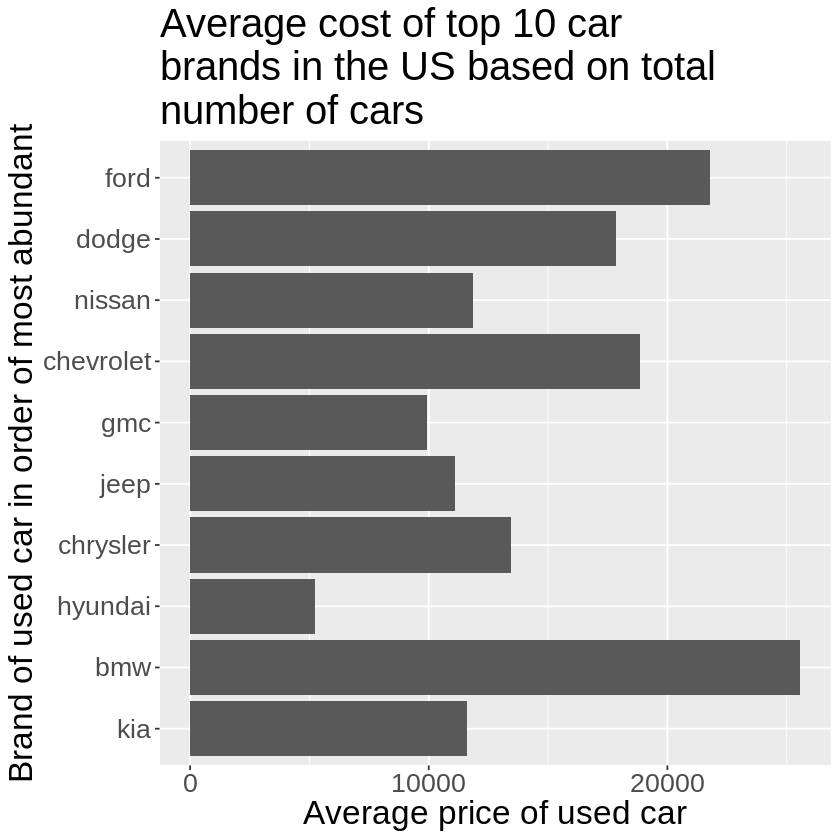

In [11]:
car_avg_common <- car_avg |>
                 slice(1:10)
eda_plot <- car_avg_common |>
            ggplot(aes(x=avg_price, y=fct_reorder(brand, count, .desc = FALSE))) +
            geom_bar(stat="identity") +
            labs(x="Average price of used car",
            y="Brand of used car in order of most abundant") +
            theme(text = element_text(size = 20)) +
            ggtitle("Average cost of top 10 car \nbrands in the US based on total \nnumber of cars")

eda_plot

**Methods**

To conduct our data analysis, we will look at only mileage, year of the car, and the brand. The lot number, vin number, state, and the day the listing was uploaded doens't make a difference. We can visualize our results with many scatterplots. We can use a scatterplot with price on the y axis and year/mileage on the x axis then have a bar plot with price on the x axis and brand on the y axis (like the graph above). We can also get an accuracy number if we use a model knn regression.

**Expected Outcomes and significance**

We can expect used BMWs Fords to cost more than the average used car. We can expect the cost of a random used car to be around between 6000 and $22000 USD based on the top 10 most abundant used cars. Being able to estimate the cost of a used car based on brand, mileage, and year can give us knowledge to whether a used car is a good deal to buy. This analysis can bring insight to the question of how much can designer brand cars with high mileage be cheaper than cheap brand cars with low mileage.
